## CV Job Matching using Doc2Vec

### Introduction
CV Job Matching using Doc2Vec is a technique that aims to match job descriptions with resumes by representing them as numerical vectors using the Doc2Vec model. This approach allows for efficient comparison and similarity calculation between textual documents.

In the field of machine learning, representing text documents numerically is a challenging task. However, it is essential for various applications, such as document retrieval, web search, spam filtering, and topic modeling. Doc2Vec, a variation of the Word2Vec algorithm, provides a solution by generating vector representations from words.

**Word2Vec** algorithms, such as **Continuous Bag-of-Words (CBOW)** and **Skip-Gram**, are used to create Word2Vec representations. CBOW predicts the current word based on the surrounding words in a sliding window context. Each word is then converted into a feature vector, and these vectors become the word vectors after training. On the other hand, Skip-Gram predicts the surrounding words given the current word. It is slower than CBOW but is known for its accuracy with infrequent words.

### Implementation

To implement CV Job Matching using Doc2Vec, we start by importing the necessary libraries and loading the job data from a CSV file. We preprocess the data, keeping only the relevant columns, and merge them into a new column called 'data.' Then, we tokenize the words in the 'data' column and tag them with unique identifiers using the TaggedDocument class.

Next, we initialize the Doc2Vec model with specific parameters, such as the vector size, minimum count, and number of epochs. We build the vocabulary by feeding the tagged data to the model, and then train the model on the tagged data.

After training, we save the model for future use. To match a resume with a job description, we load the saved model and preprocess the resume and job description text. We convert them to lowercase, remove punctuation and numerical values.

Using the trained model, we infer the document vectors for the resume and job description. Then, we calculate the cosine similarity between the two vectors to determine the match between the resume and the job description. The cosine similarity score ranges from -1 to 1, with 1 indicating a perfect match and -1 indicating no similarity.

By employing Doc2Vec and cosine similarity, this approach enables efficient and effective matching between job descriptions and resumes, helping to streamline the job application process and enhance the chances of finding the right candidates for specific positions.

Finally, the author also employs Gauge chart from Plotly to show the matching percentage with threshold that users could consider modifying thier CV to pass Application Tracking System (TSA) from the majority of employers.

### Coding
#### 1. Set up

In [3]:
## Install all dependencies
# !pip install gensim
# !pip install nltk
# !pip install pandas
# !pip install numpy
# !pip install requests
#!pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.6 MB/s eta 0:00:00a 0:00:01


In [40]:
# Import libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from numpy.linalg import norm
from termcolor import colored
import pandas as pd
import numpy as np
import requests
import PyPDF2
import re
import plotly.graph_objects as go
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Kirudang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 2. Prepare data
This dataset that we trained our model contains current job postings available on the City of New York’s official jobs site in 2020. You can follow this link to download: 
[New York Job Posting Dataset](https://data.world/city-of-ny/kpav-sd4t)

In [42]:
# Load data
df = pd.read_csv('./dataset/nyc-jobs-1.csv')
# Check data
df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,1,,,...,"Salary range for this position is: $42,405 - $...",,,,NaN,New York City residency is generally required ...,2011-06-24T00:00:00,NaN,2011-06-24T00:00:00,2018-07-17T00:00:00
1,97899,DEPARTMENT OF BUSINESS SERV.,Internal,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,10009,M3,,F,...,,"In addition to applying through this website, ...",,,NaN,New York City residency is generally required ...,2012-01-26T00:00:00,NaN,2012-01-26T00:00:00,2018-07-17T00:00:00
2,102221,DEPT OF ENVIRONMENT PROTECTION,External,1,Project Specialist,ENVIRONMENTAL ENGINEERING INTE,20616,0,,F,...,Appointments are subject to OMB approval,click the apply now button,35 hours per week/day,,NaN,New York City Residency is not required for th...,2012-06-21T00:00:00,NaN,2012-09-07T00:00:00,2018-07-17T00:00:00
3,102221,DEPT OF ENVIRONMENT PROTECTION,Internal,1,Project Specialist,ENVIRONMENTAL ENGINEERING INTE,20616,0,,F,...,Appointments are subject to OMB approval,click the apply now button,35 hours per week/day,,NaN,New York City Residency is not required for th...,2012-06-21T00:00:00,NaN,2012-09-07T00:00:00,2018-07-17T00:00:00
4,114352,DEPT OF ENVIRONMENT PROTECTION,Internal,5,Deputy Plant Chief,SENIOR STATIONARY ENGINEER (EL,91639,0,,F,...,Appointments are subject to OMB approval Fo...,"Click ""Apply Now"" button",40 per week / day,Various,NaN,New York City residency is generally required ...,2012-12-12T00:00:00,NaN,2012-12-13T00:00:00,2018-07-17T00:00:00


Since head() fuction does not show all data, we check column names to retain only necessary variables.

In [43]:
# Show column name
df.columns

Index(['Job ID', 'Agency', 'Posting Type', '# Of Positions', 'Business Title',
       'Civil Service Title', 'Title Code No', 'Level', 'Job Category',
       'Full-Time/Part-Time indicator', 'Salary Range From', 'Salary Range To',
       'Salary Frequency', 'Work Location', 'Division/Work Unit',
       'Job Description', 'Minimum Qual Requirements', 'Preferred Skills',
       'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1',
       'Recruitment Contact', 'Residency Requirement', 'Posting Date',
       'Post Until', 'Posting Updated', 'Process Date'],
      dtype='object')

Keep only some columns to train the model

In [44]:
df =df[['Business Title', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills']]
df.head()

,Business Title,Job Description,Minimum Qual Requirements,Preferred Skills
0,Account Manager,Division of Economic & Financial Opportunity (...,1.\tA baccalaureate degree from an accredited ...,â€¢\tExcellent interpersonal and organizationa...
1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",The New York City Department of Small Business...,1. A baccalaureate degree from an accredited c...,
2,Project Specialist,"Under direct supervision, perform elementary e...",A Baccalaureate degree from an accredited coll...,
3,Project Specialist,"Under direct supervision, perform elementary e...",A Baccalaureate degree from an accredited coll...,
4,Deputy Plant Chief,"Under general direction, is in responsible cha...",1. Six years of full-time satisfactory experie...,


In [45]:
# Create a new column called 'data' and merge the values of the other columns into it
df['data'] = df[['Business Title', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
# Drop the individual columns if you no longer need them
df.drop(['Business Title', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills'], axis=1, inplace=True)
# Preview the updated dataframe
print(df.head())

                                                data
0  Account Manager Division of Economic & Financi...
1  EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT The N...
2  Project Specialist Under direct supervision, p...
3  Project Specialist Under direct supervision, p...
4  Deputy Plant Chief Under general direction, is...


#### 3. Tokenize data
We tokenize the words in the 'data' column and tag them with unique identifiers using the TaggedDocument class.

In [46]:
# Tag data
data = list(df['data'])
tagged_data = [TaggedDocument(words = word_tokenize(_d.lower()), tags = [str(i)]) for i, _d in enumerate(data)]

#### 4. Model initialization and vocabulary buiding
Next, we initialize the Doc2Vec model with specific parameters.

**Parameters** of Doc2Vec are as follows: 

- `vector_size`: Dimensionality of the feature vectors. Default: 100.
- `window`: The window refers to the maximum distance between the target word and its context words within a sentence. Default: 5.
- `min_count`: Ignores all words with a total frequency lower than this. Default: 5.
- `epochs`: Number of iterations (epochs) over the corpus. Defaults to 5 for PV-DBOW and 10 for PV-DM.
- `dm`: Defines the training algorithm. If `dm = 1`, the Distributed Memory (PV-DM) model is used. If `dm = 0`, the Distributed Bag of Words (PV-DBOW) model is used. Default: 1 (PV-DM).
- `dbow_words`: If set to 1, trains word vectors (in addition to document vectors) using the PV-DBOW algorithm. Default: 0 (False).
- `dm_mean`: If set to 1, uses the mean of the context word vectors instead of concatenation when inferring vectors in the PV-DM model. Default: 0 (False).
- `dm_concat`: If set to 1, concatenates the document and context word vectors when inferring vectors in the PV-DM model. Default: 0 (False).
- `dm_tag_count`: Expected number of document tags per document, when using the PV-DM algorithm. Default: 1.
- `dbow_tag_count`: Expected number of document tags per document, when using the PV-DBOW algorithm. Default: 1.
- `alpha`: The initial learning rate. Default: 0.025.
- `min_alpha`: The learning rate will linearly drop to `min_alpha` as training progresses. Default: 0.0001.
- `hs`: If set to 1, hierarchical softmax activation function will be used. Default: 0 (Negative Sampling).
- `negative`: If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drawn. Default: 5.
- `ns_exponent`: The exponent used to shape the negative sampling distribution. Default: 0.75.


In [51]:
# Model initialization
model = Doc2Vec(vector_size = 50,
min_count = 5,
epochs = 100,
alpha = 0.001
)

In [52]:
# Vocabulary building
model.build_vocab(tagged_data)
# Get the vocabulary keys
keys = model.wv.key_to_index.keys()
# Print the length of the vocabulary keys
print(len(keys))

8599


#### 5. Train and save the model
Train the model on tagged data.

In [53]:
# Train the model
for epoch in range(model.epochs):
    print(f"Training epoch {epoch+1}/{model.epochs}")
    model.train(tagged_data, 
                total_examples=model.corpus_count, 
                epochs=model.epochs)

model.save('cv_job_maching.model')
print("Model saved")

Training epoch 1/100
Training epoch 2/100
Training epoch 3/100
Training epoch 4/100
Training epoch 5/100
Training epoch 6/100
Training epoch 7/100
Training epoch 8/100
Training epoch 9/100
Training epoch 10/100
Training epoch 11/100
Training epoch 12/100
Training epoch 13/100
Training epoch 14/100
Training epoch 15/100
Training epoch 16/100
Training epoch 17/100
Training epoch 18/100
Training epoch 19/100
Training epoch 20/100
Training epoch 21/100
Training epoch 22/100
Training epoch 23/100
Training epoch 24/100
Training epoch 25/100
Training epoch 26/100
Training epoch 27/100
Training epoch 28/100
Training epoch 29/100
Training epoch 30/100
Training epoch 31/100
Training epoch 32/100
Training epoch 33/100
Training epoch 34/100
Training epoch 35/100
Training epoch 36/100
Training epoch 37/100
Training epoch 38/100
Training epoch 39/100
Training epoch 40/100
Training epoch 41/100
Training epoch 42/100
Training epoch 43/100
Training epoch 44/100
Training epoch 45/100
Training epoch 46/1

#### 6. Inputs of CV and JD

- **Resume**:

In this case, I assume that we upload our CV in PDF file, so I use PyPDF2 to extract data. You can also change how to read inputs appropreately.

In [55]:
pdf = PyPDF2.PdfReader('./CV/Quy-Pham-Resume-Official.pdf')
resume = ""
for i in range(len(pdf.pages)):
    pageObj = pdf.pages[i]
    resume += pageObj.extract_text()

- **Job Description**:

From my perspective, I believe candidates will copy and paste the JD into textbox to check the matching percentage, so I will have JD Input in text as below.

In [56]:
# JD by input text:
jd = input("Paste your JD here: ")

Paste your JD here:  Proactively engage with clients in the branch and deliver an outstanding service experience through completing transactions and by identifying opportunities for advice, solutions, digital enablement and partner introductions Focus on education and demonstration, leverage technology to deliver a memorable client experience, drive solutions and retain business Contribute to team results by listening and spotting opportunities to offer additional advice, introduce clients to the capability of RBC partners, or personally fulfil client solutions Proactively take ownership of resolving and preventing client banking problems Cultivate and maintain relationships with partners to work as one RBC team Manage risks by adhering to compliance routines, processes, and controls to protect client and shareholder interests while completing transactions What do you need to succeed?  Must-have  Goal-oriented individual with a demonstrated passion for putting clients first. Drive and 

In [37]:
jd = """
Proactively engage with clients in the branch and deliver an outstanding service experience through completing transactions and by identifying opportunities for advice, solutions, digital enablement and partner introductions
Focus on education and demonstration, leverage technology to deliver a memorable client experience, drive solutions and retain business
Contribute to team results by listening and spotting opportunities to offer additional advice, introduce clients to the capability of RBC partners, or personally fulfil client solutions
Proactively take ownership of resolving and preventing client banking problems
Cultivate and maintain relationships with partners to work as one RBC team
Manage risks by adhering to compliance routines, processes, and controls to protect client and shareholder interests while completing transactions
What do you need to succeed?

Must-have

Goal-oriented individual with a demonstrated passion for putting clients first.
Drive and self-motivation, as well as excellent communication skills and emotional intelligence
Digital literacy across a broad range of devices (i.e., smartphones, tablets, laptops, etc.)
Personal flexibility to work flex hours
Eagerness to learn and determination to succeed
Confidence and ability to learn financial concepts and willingness to obtain the Investment Funds in Canada or the Canadian Securities Course
Nice-to-have

Track record in building rapport and maintaining client relationships within the financial, service or retail industry
Mutual Funds accreditation
Is this job right for you? Check out our video and decide for yourself!

What’s in it for you?

We thrive on the challenge to be our best, progressive thinking to keep growing, and working together to deliver trusted advice to help our clients thrive and communities prosper. We care about each other, reaching our potential, making a difference to our communities, and achieving success that is mutual.

A comprehensive Total Rewards Program including bonuses and flexible benefits, competitive compensation, commissions, and stock where applicable
A world-class training program in financial services
Excellent career development and access to a variety of job opportunities across business and geographies
Leaders who support your development through coaching and managing opportunities
Work in a dynamic, collaborative, progressive, and high-performing team
We also strive to provide an accessible candidate experience for our prospective employees with different abilities. Please let us know if you need any accommodations during the recruitment process.

Join our Talent Community

Stay in-the-know about great career opportunities at RBC. Sign up and get customized info on our latest jobs, career tips and Recruitment events that matter to you.

Expand your limits and create a new future together at RBC. Find out how we use our passion and drive to enhance the well-being of our clients and communities at rbc.com/careers.
"""

- **Develop a function to pre-process input text**:

In [57]:
def preprocess_text(text):
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove punctuation from the text
    text = re.sub('[^a-z]', ' ', text)
    
    # Remove numerical values from the text
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespaces
    text = ' '.join(text.split())
    
    return text

In [58]:
# Apply to CV and JD
input_CV = preprocess_text(resume)
input_JD = preprocess_text(jd)

#### 7. Matching
Using the trained model, we infer the document vectors for the resume and job description. Then, we calculate the cosine similarity between the two vectors to determine the match between the resume and the job description.

In [59]:
# Model evaluation
model = Doc2Vec.load('cv_job_maching.model')
v1 = model.infer_vector(input_CV.split())
v2 = model.infer_vector(input_JD.split())
similarity = 100*(np.dot(np.array(v1), np.array(v2))) / (norm(np.array(v1)) * norm(np.array(v2)))
print(round(similarity, 2))

52.28


#### 8. Visualization and Notification

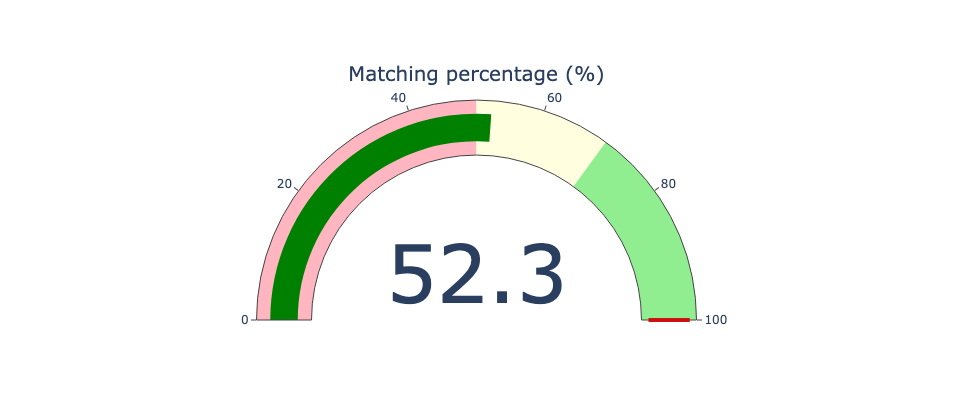

Good chance but you can improve further!


In [76]:
# Visualization
fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = similarity,
    mode = "gauge+number",
    title = {'text': "Matching percentage (%)"},
    #delta = {'reference': 100},
    gauge = {
        'axis': {'range': [0, 100]},
        'steps' : [
            {'range': [0, 50], 'color': "#FFB6C1"},
            {'range': [50, 70], 'color': "#FFFFE0"},
            {'range': [70, 100], 'color': "#90EE90"}
        ],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 100}}))

fig.update_layout(width=600, height=400)  # Adjust the width and height as desired
fig.show()

# Print notification
if similarity < 50:
    print(colored("Low chance, need to modify your CV!", "red", attrs=["bold"]))
elif similarity >= 50 and similarity < 70:
    print(colored("Good chance but you can improve further!", "yellow", attrs=["bold"]))
else:
    print(colored("Excellent! You can submit your CV.", "green", attrs=["bold"]))